In [63]:
import pandas as pd
import numpy as np
data = pd.read_csv('./data/data_earthquake.csv',low_memory = False)
print(len(data.columns))
data.drop(np.arange(0,10), axis = 0,inplace = True)
data.columns = ['NUM','YEAR','MONTH','DATE','UTC','IST','MW','Mw','MB','Mb','MS','ML','LAT','LONG','DEPTH','NLOCATION1','NLOCATION2','NLOCATION3','LOCATION','REF']
data.drop(['NUM','UTC','IST','MW','MB','Mb','MS','ML','NLOCATION1','NLOCATION2','NLOCATION3','LOCATION'],axis = 1, inplace = True)
data['YEAR'].fillna(0)
data['MONTH'].fillna(0)
data['DATE'].fillna(0)
data['DEPTH'].fillna(0)
temp = pd.to_numeric(data.YEAR.astype(str).str.replace(',',''), errors='coerce').fillna(0).astype(int)
data['YEAR'] = temp
temp = pd.to_numeric(data.MONTH.astype(str).str.replace(',',''), errors='coerce').fillna(0).astype(int)
data['MONTH'] = temp
temp = pd.to_numeric(data.DATE.astype(str).str.replace(',',''), errors='coerce').fillna(0).astype(int)
data['DATE'] = temp
temp = pd.to_numeric(data.DEPTH.astype(str).str.replace(',',''), errors='coerce').fillna(0).astype(int)
data['DEPTH'] = temp

data['REF'].fillna('NONE',inplace = True)

# all_loc = pd.notnull(data['LOCATION'])
all_lat = pd.notnull(data['LAT'])
all_long = pd.notnull(data['LONG'])
data_avail = pd.notnull(data['Mw'])

all_lat_long = all_lat & all_long
to_be_considered = all_lat_long & data_avail
data = data[to_be_considered]

data['Mw'].fillna('0',inplace=True)

20


In [6]:
data.index = np.arange(0,50485)
data.dtypes

YEAR      int64
MONTH     int64
DATE      int64
Mw       object
LAT      object
LONG     object
DEPTH     int64
REF      object
dtype: object

In [7]:
METAVAL = 43

temp = []
for val in data['Mw']:
    sdot = 0
    np = 0
    for j in val:
        if (j>='0' and j<='9'):
            continue
        elif (sdot == 0 and j == '.'):
            sdot = 1
        else:
            np = 1
            break;
    nuval = 0
    if np == 1:
        nuval = 0
    else:
        value = round(float(val),1)
        value = int(value*10)
        nuval = value
    if nuval>METAVAL:
        nuval = 1
    else:
        nuval = 0
    temp.append(nuval)
data['Mw'] = pd.Series(temp)
data.dtypes

YEAR      int64
MONTH     int64
DATE      int64
Mw        int64
LAT      object
LONG     object
DEPTH     int64
REF      object
dtype: object

In [8]:
temp = []
for val in data['LAT']:
    sdot = 0
    np = 0
    for j in range(len(val)):
        k = val[j]
        if (k>='0' and k<='9'):
            continue
        elif (sdot == 0 and k == '.'):
            sdot = 1
        else:
            np = 1
            break;
    curval = val[:j]
    if len(curval) == 0:
        temp.append(0)
        continue
    value = round(float(curval),1)
    value = int(value*10)
    temp.append(value)
data['LAT'] = pd.Series(temp)
temp = []
for val in data['LONG']:
    sdot = 0
    np = 0
    for j in range(len(val)):
        k = val[j]
        if (k>='0' and k<='9'):
            continue
        elif (sdot == 0 and k == '.'):
            sdot = 1
        else:
            np = 1
            break;
    curval = val[:j]
    if len(curval) == 0:
        temp.append(0)
        continue
    value = round(float(curval),1)
    value = int(value*10)
    temp.append(value)
data['LONG'] = pd.Series(temp)

import json

REFERERS = set(data['REF'])
MAP_REF_TO_NUM = {}
ctr = 0

for i in REFERERS:
    MAP_REF_TO_NUM[i] = ctr
    ctr += 1

with open('./data/referers.json','w') as fp:
    json.dump(MAP_REF_TO_NUM, fp)
    
nuref = []
for val in data['REF']:
    nuref.append(MAP_REF_TO_NUM[val])
data['REF'] = pd.Series(nuref)
data.dtypes

YEAR     int64
MONTH    int64
DATE     int64
Mw       int64
LAT      int64
LONG     int64
DEPTH    int64
REF      int64
dtype: object

In [9]:
data

,YEAR,MONTH,DATE,Mw,LAT,LONG,DEPTH,REF
0,-2474,0,0,1,70,20,0,23
1,-325,0,0,1,70,20,0,23
2,25,0,0,1,720,337,0,23
3,26,5,10,1,170,800,0,5
4,26,5,10,1,20,90,80,9
...,...,...,...,...,...,...,...,...
50480,2019,7,28,0,328,784,10,7
50481,2019,7,28,0,255,904,70,7
50482,2019,7,28,0,232,865,22,7
50483,2019,7,29,0,328,764,20,7


In [10]:
data.to_csv('./data/preprocessed.csv')

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import joblib
from sklearn.tree import export_graphviz

X = data.drop(columns = 'Mw')
Y = data['Mw']

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3,random_state = 1)

'[1 0]'

# Performing generally uptil maximum depth [46 in this case]

In [22]:
import graphviz
model_decision_tree = DecisionTreeClassifier()
model_decision_tree.fit(X_train,Y_train)
classname = ['0','1']
dot_data = export_graphviz( model_decision_tree,
out_file=None, feature_names=['YEAR','MONTH','DATE','LAT','LONG','DEPTH','REF'], class_names=classname, rounded=True,
            filled=True
        )
graph = graphviz.Source(dot_data, format='png')
graph.render("decision_tree_graphivz")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0786385 to fit


'decision_tree_graphivz.png'

In [11]:
joblib.dump(model_decision_tree,'./data_models/DecisionTree.joblib')

['./data_models/DecisionTree.joblib']

In [12]:
Y_pred = model_decision_tree.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score
ctr = 0
i = 0
for true_value in Y_test:
    predicted_value = Y_pred[i]
    if predicted_value == true_value:
        ctr+=1
    i += 1
tot = i
accuracy = ctr/tot
print(accuracy)
score = accuracy_score(Y_test, Y_pred)
print(score)

0.643998415423214
0.643998415423214


In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [18]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, Y_pred)
print('roc_auc_score for DecisionTree: ', roc_auc_score(Y_test, Y_pred))

roc_auc_score for DecisionTree:  0.6318094395027779
[0.         0.43651559 1.        ]
[0.         0.70013447 1.        ]


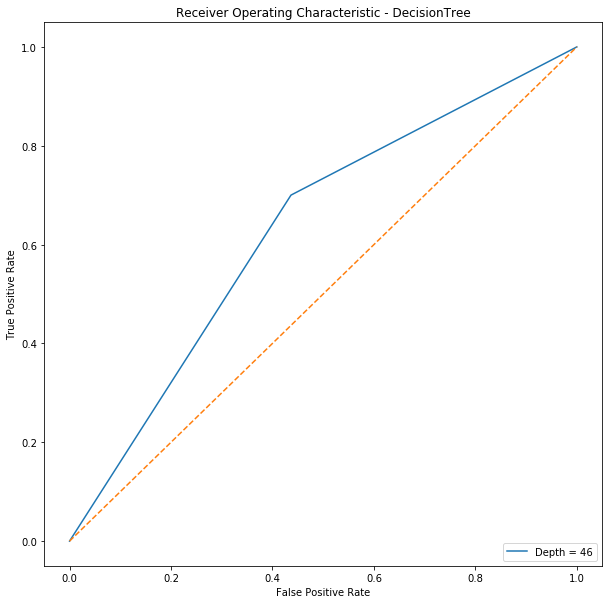

In [22]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(false_positive_rate1, true_positive_rate1,label = 'Depth = 46')
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc ="lower right")
plt.show()

In [23]:
mdepth = model_decision_tree.tree_.max_depth

# Performing for different Depths now

roc_auc_score for DecisionTree:  0.651235491073519
depth:  5

roc_auc_score for DecisionTree:  0.6855477217450088
depth:  10

roc_auc_score for DecisionTree:  0.6743696475584893
depth:  15

roc_auc_score for DecisionTree:  0.6517012261547601
depth:  20

roc_auc_score for DecisionTree:  0.6383518647629233
depth:  25

roc_auc_score for DecisionTree:  0.6348733856138071
depth:  30

roc_auc_score for DecisionTree:  0.6331637272407549
depth:  35

roc_auc_score for DecisionTree:  0.6320534191294436
depth:  40

roc_auc_score for DecisionTree:  0.6337793764293528
depth:  45



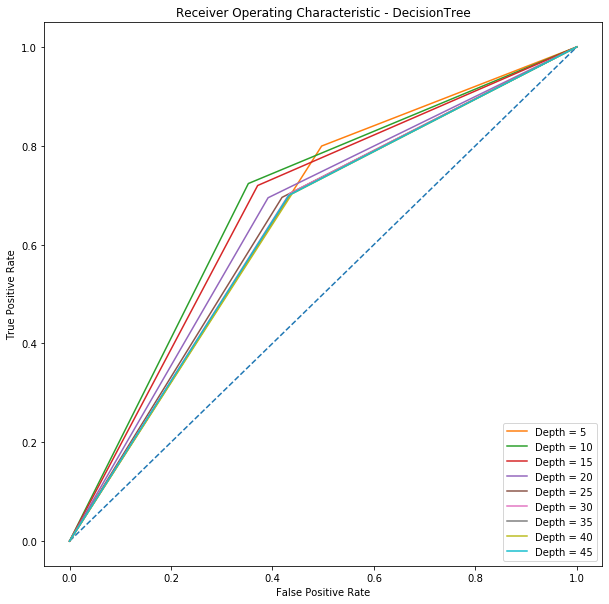

In [30]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

maxi_score = 0
maxi = 0
step_depth = 5

for i in range(0,mdepth+1,step_depth):
    if i == 0:
        continue
    model_decision_tree = DecisionTreeClassifier(max_depth = i)
    model_decision_tree.fit(X_train,Y_train)
    Y_pred = model_decision_tree.predict(X_test)
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, Y_pred)
    score = roc_auc_score(Y_test, Y_pred)
    if score > maxi_score:
        maxi_score = score
        maxi = i
    print('roc_auc_score for DecisionTree: ', score)
    print('depth: ',i)
    print()
    plt.plot(false_positive_rate1, true_positive_rate1,label = 'Depth = ' +str(i))

plt.legend(loc ="lower right")
plt.show()

In [31]:
print('Best depth among all that are tested is: ',maxi)

Best depth among all that are tested is:  10


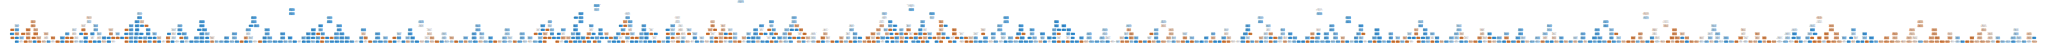

In [24]:
model_decision_tree = DecisionTreeClassifier(max_depth = 10)
model_decision_tree.fit(X_train,Y_train)
dot_data = export_graphviz( model_decision_tree,
out_file=None, feature_names=['YEAR','MONTH','DATE','LAT','LONG','DEPTH','REF'], class_names=classname, rounded=True,
            filled=True
        )
graph = graphviz.Source(dot_data, format='png')
graph

roc_auc_score for nearest_neighbor:  0.62558042189475
neighbors:  1

roc_auc_score for nearest_neighbor:  0.6667703134335863
neighbors:  6

roc_auc_score for nearest_neighbor:  0.6646252846098797
neighbors:  11

roc_auc_score for nearest_neighbor:  0.679602179395246
neighbors:  16

roc_auc_score for nearest_neighbor:  0.6734070563511353
neighbors:  21

roc_auc_score for nearest_neighbor:  0.6782614891045365
neighbors:  26

roc_auc_score for nearest_neighbor:  0.6717909232014738
neighbors:  31

roc_auc_score for nearest_neighbor:  0.6736535033291593
neighbors:  36

roc_auc_score for nearest_neighbor:  0.6697412926270067
neighbors:  41

roc_auc_score for nearest_neighbor:  0.6750894838099247
neighbors:  46



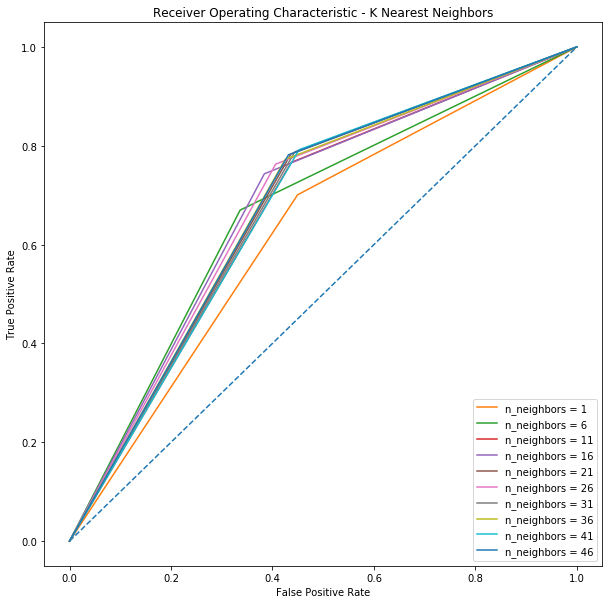

In [34]:
from sklearn.neighbors import KNeighborsClassifier
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - K Nearest Neighbors')
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

maxi_score = 0
maxi = 0
step_neighbor = 5
max_neighbors = 50

for i in range(1,max_neighbors,step_neighbor):
    model_nearest_neighbor = KNeighborsClassifier(n_neighbors = i)
    model_nearest_neighbor.fit(X_train,Y_train)
    Y_pred = model_nearest_neighbor.predict(X_test)
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, Y_pred)
    score = roc_auc_score(Y_test, Y_pred)
    if score > maxi_score:
        maxi_score = score
        maxi = i
    print('roc_auc_score for nearest_neighbor: ', score)
    print('neighbors: ',i)
    print()
    plt.plot(false_positive_rate1, true_positive_rate1,label = 'n_neighbors = ' +str(i))

plt.legend(loc ="lower right")
plt.show()

In [33]:
print('Best depth among all that are tested is: ',maxi)

Best depth among all that are tested is:  16


roc_auc_score for ensemble learning:  0.6223825544355341
num_estimators:  1

roc_auc_score for ensemble learning:  0.6976271175817912
num_estimators:  121

roc_auc_score for ensemble learning:  0.6983554905087297
num_estimators:  241

roc_auc_score for ensemble learning:  0.6963487234104171
num_estimators:  361

roc_auc_score for ensemble learning:  0.6969230759810224
num_estimators:  481

roc_auc_score for ensemble learning:  0.6980900791439869
num_estimators:  601

roc_auc_score for ensemble learning:  0.6984432165559349
num_estimators:  721

roc_auc_score for ensemble learning:  0.6964313166464019
num_estimators:  841

roc_auc_score for ensemble learning:  0.6956056184147833
num_estimators:  961



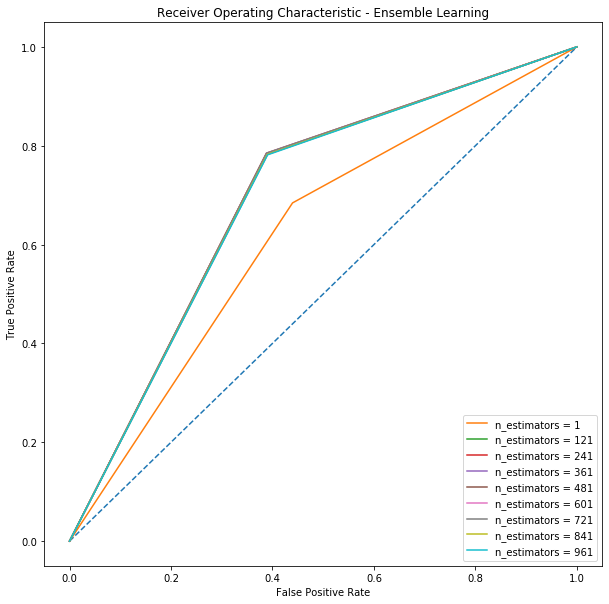

In [38]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Ensemble Learning')
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

maxi_score = 0
maxi = 0
step_estimator = 120
max_estimators = 1000

for i in range(1,max_estimators,step_estimator):
    bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=i,max_samples=10000, bootstrap=False)
    bag_clf.fit(X_train, Y_train)
    Y_pred = bag_clf.predict(X_test)
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, Y_pred)
    score = roc_auc_score(Y_test, Y_pred)
    if score > maxi_score:
        maxi_score = score
        maxi = i
    print('roc_auc_score for ensemble learning: ', score)
    print('num_estimators: ',i)
    print()
    plt.plot(false_positive_rate1, true_positive_rate1,label = 'n_estimators = ' +str(i))

plt.legend(loc ="lower right")
plt.show()

In [39]:
print('Number of optimal estimators : ',maxi)

Number of optimal estimators :  721


In [68]:
data = pd.read_csv('./data/preprocessed.csv')
data

,Unnamed: 0,YEAR,MONTH,DATE,Mw,LAT,LONG,DEPTH,REF
0,0,-2474,0,0,1,70,20,0,23
1,1,-325,0,0,1,70,20,0,23
2,2,25,0,0,1,720,337,0,23
3,3,26,5,10,1,170,800,0,5
4,4,26,5,10,1,20,90,80,9
...,...,...,...,...,...,...,...,...,...
50480,50480,2019,7,28,0,328,784,10,7
50481,50481,2019,7,28,0,255,904,70,7
50482,50482,2019,7,28,0,232,865,22,7
50483,50483,2019,7,29,0,328,764,20,7


In [88]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score


#for two features YEAR with LONG was maximum axxuracy,depth of decision tree was 10 nestimator = 500
#max accuracy achieved for test_size = 0.2 with YEAR,LONG,LAT nestimator = 500

Y = data['Mw']
COMBI_LAT_LONG = data['LONG'].combine(data['LAT'],(lambda x1, x2: int(x1*1000+x2)))
COMBI_DATE = data['DATE'].combine(data['MONTH'],(lambda x1, x2: int(x1 +x2*31)))
COMBI_YEAR = data['YEAR'].combine(COMBI_DATE,(lambda x1, x2: int(x1*12 +x2)))
data['COMBI_LOC'] = COMBI_LAT_LONG
data['COMBI_DATE'] = COMBI_YEAR
X = data[['COMBI_LOC','REF']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth = 10), n_estimators=400, bootstrap=False)
bag_clf.fit(X_train, Y_train)
Y_pred = bag_clf.predict(X_test)
score = accuracy_score(Y_test,Y_pred)
print("Bagging Accuracy: ",score)
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, Y_pred)
score = roc_auc_score(Y_test, Y_pred)
print('roc_auc_score: ', score)

Bagging Accuracy:  0.6262256115677924
roc_auc_score:  0.5928218133135956
